In [3]:
import pymongo
import math 
# import re
import pandas as pd
import numpy as np
import pylab 
from matplotlib import pyplot as plt
# from scipy import stats 
from  qgrid import show_grid as show 
from datetime import datetime

import seaborn as sns
import re
import matplotlib as mpl 
%matplotlib inline
mpl.style.use('ggplot')


def getPowers(data):
    data["m"]=data.metadata.apply(lambda row:row["scope"]+" "+row["socket"])
    data["tt"]=data.apply(lambda row: (row["target"],row["timestamp"]),axis=1)
    powers=data.pivot(index="tt",columns="m",values="power")
    powers["ind"]=powers.index 
    powers["timestamp"]=powers["ind"].apply(lambda row:row[1])
    powers["target"]=powers["ind"].apply(lambda row:row[0])
    powers["sensor"]=data["sensor"][1]
    powers=powers.drop("ind",axis=1)
    powers["cpu"]=powers.apply(lambda row: row["cpu 0"]+row["cpu 1"],axis =1 )
    powers["dram"]=powers.apply(lambda row: row["dram 0"]+row["dram 1"],axis =1 )
    return powers


def getTimes(data): 
    x=data
    times=pd.DataFrame()
    times["begin"]=x.groupby("target")["timestamp"].min()
    times["end"]=x.groupby("target")["timestamp"].max()
#     times["name"]=times.index
#     times[["mode","mode2","benchmark","class","cpu number","p","number"]]=times["name"].str.split("_",expand=True)
#     times["number"]=times.apply(lambda row:int(row["p"]) if row["number"]==None else int(row["number"]),axis=1)
    times["sensor"]=data["sensor"][1]
    return times

def getEnergy(machinename):   
    data=pd.DataFrame(list(db["power"+machinename].find()))
    x=getPowers(data)
    y=getTimes(data) 
    x=x.dropna()
#     y=times
    y["target"]=y.index
    z=y.drop(["powerapi-sensor","rapl","system","global","kernel"])
    z[["rapl"]]=z.apply(lambda row:x.loc[np.logical_and(np.logical_and(x["target"]=="rapl",np.logical_and(row["end"]>=x["timestamp"],x["timestamp"]>= row["begin"])),x["sensor"]==row["sensor"]),["cpu"]].apply(np.trapz),axis=1)
    z[["kernel"]]=z.apply(lambda row:x.loc[np.logical_and(np.logical_and(x["target"]=="kernel",np.logical_and(row["end"]>=x["timestamp"],x["timestamp"]>= row["begin"])),x["sensor"]==row["sensor"]),["cpu"]].apply(np.trapz),axis=1)
    z[["system"]]=z.apply(lambda row:x.loc[np.logical_and(np.logical_and(x["target"]=="system",np.logical_and(row["end"]>=x["timestamp"],x["timestamp"]>= row["begin"])),x["sensor"]==row["sensor"]),["cpu"]].apply(np.trapz),axis=1)
    z["program"]=z.apply(lambda row :x.loc[x["target"]==row["target"],["cpu"]].apply(np.trapz),axis=1)
    return z


def cleanData(data,groupobj=["typ","machineName"],measure="energy_PKG_all"): 
    l=pd.DataFrame()
    for j in data.groupby(groupobj): 
        dt=pd.DataFrame(j[1])
#         dt["type"]=j[0][0]
#         dt["machine Name"]=j[0][1]
        q1=dt[measure].quantile(0.25)
        q3=dt[measure].quantile(0.75)
        irq=q3-q1
        mini= q1-1.5*irq
        maxi= q3+1.5*irq
        dt=dt[((mini<=dt[measure]) & (dt[measure]<=maxi))]
        l=pd.concat([l,dt], sort=False)
    return l

In [4]:
sns.set_style("whitegrid") 
fig=plt.figure(figsize=(10,6))

<Figure size 720x432 with 0 Axes>

In [5]:
serveraddr = '172.16.45.8'
serverport=27017
db = pymongo.MongoClient(serveraddr, serverport)["variation"]
# data=pd.DataFrame(list(db["powersmartwattstest"].find()))
# show(data)


In [6]:
machinenames=["xdockervsbinarryxep","xdockervsbinarryxcg"]
energies=[getEnergy(i) for i in machinenames]
enegy=pd.concat(energies)

In [27]:
# enegy.to_csv("smartwattsvsrapl")
energy2=enegy.copy()
energy2=energy2.dropna()


In [31]:
energy2["os"]=energy2.apply(lambda row:row["system"]+row["kernel"],axis=1)
energy2.drop(["system","kernel"],axis=1)
energy2["sensor"]=energy2["sensor"].apply(lambda row : row.split(".")[0])
energy2["mode"]=energy2["target"].apply(lambda row:row.split("_")) 

In [33]:
show(energy2)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [21]:
dt2=energy2.melt(id_vars=["target","begin","end","sensor"],var_name="methode",value_name="energy")

In [26]:
energy2["mode"]=energy2["target"].apply(lambda row:row.split("_")[2] )
energy2["number"]=energy2["target"].apply(lambda row:int(row.split("_")[-1]) )
energy3=energy2.copy()
# energy3=cleanData(energy3,groupobj=["sensor","mode"],measure="os")
# energy3=cleanData(energy3,groupobj=["sensor","mode"],measure="rapl")
# energy3=cleanData(energy3,groupobj=["sensor","mode"],measure="self")
# energy3=cleanData(energy3,groupobj=["sensor","mode"],measure="rapl")
energy3=energy3.drop(["begin","end","kernel","system"],axis=1)
energy3.groupby(["sensor","mode"]).std()

rapl       program  number
sensor                      mode                                    
dahu-9.grenoble.grid5000.fr 1     13874.619226  12702.966746     0.0
                            10    14246.541209  13842.520252     0.0
                            100            NaN           NaN     NaN
                            11    14406.306816  14200.978342     0.0
                            12    14235.922566  13933.468335     0.0
                            13    14097.770996  13795.724841     0.0
                            14    14251.650405  13802.615020     0.0
                            15             NaN           NaN     NaN
                            16             NaN           NaN     NaN
                            17             NaN           NaN     NaN
                            18             NaN           NaN     NaN
                            19             NaN           NaN     NaN
                            2     13580.103275  13470.105183     0.0
                            20             NaN           NaN     NaN
                            21             NaN           NaN     NaN
                            22             NaN           NaN     NaN
                            23             NaN           NaN     NaN
                            24             NaN           NaN     NaN
                            25             NaN           NaN     NaN
                            26             NaN           NaN     NaN
                            27             NaN           NaN     NaN
                            28             NaN           NaN     NaN
                            29             NaN           NaN     NaN
                            3     13405.187439  13119.840808     0.0
                            30             NaN           NaN     NaN
                            31             NaN           NaN     NaN
                            32             NaN           NaN     NaN
                            33             NaN           NaN     NaN
                            34             NaN           NaN     NaN
                            35             NaN           NaN     NaN
...                                        ...           ...     ...
                            72             NaN           NaN     NaN
                            73             NaN           NaN     NaN
                            74             NaN           NaN     NaN
                            75             NaN           NaN     NaN
                            76             NaN           NaN     NaN
                            77             NaN           NaN     NaN
                            78             NaN           NaN     NaN
                            79             NaN           NaN     NaN
                            8     13597.310302  13426.836258     0.0
                            80             NaN           NaN     NaN
                            81             NaN           NaN     NaN
                            82             NaN           NaN     NaN
                            83             NaN           NaN     NaN
                            84             NaN           NaN     NaN
                            85             NaN           NaN     NaN
                            86             NaN           NaN     NaN
                            87             NaN           NaN     NaN
                            88             NaN           NaN     NaN
                            89             NaN           NaN     NaN
                            9     14069.720643  13717.803160     0.0
                            90             NaN           NaN     NaN
                            91             NaN           NaN     NaN
                            92             NaN           NaN     NaN
                            93             NaN           NaN     NaN
                            94             NaN           NaN     NaN
                            95          

In [18]:
x=energy3.loc[np.logical_and(energy3["mode"]=="CG",energy3["sensor"]=="dahu-25")]
x["somme"]=x.apply(lambda row:-row["os"]-row["self"]+row["rapl"],axis=1)

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [124]:
x

,sensor,target,rapl,self,os,mode,number,somme
target,,,,,,,,
normal_normal_CG_B_1_1,dahu-25,normal_normal_CG_B_1_1,31677.468048,20132.133620,8270.524898,CG,1,3274.809530
normal_normal_CG_B_1_10,dahu-25,normal_normal_CG_B_1_10,30671.106964,19384.846443,2695.451751,CG,10,8590.808770
normal_normal_CG_B_1_11,dahu-25,normal_normal_CG_B_1_11,29677.083099,17625.418613,11420.846748,CG,11,630.817738
normal_normal_CG_B_1_12,dahu-25,normal_normal_CG_B_1_12,31854.056152,20235.464976,4557.402597,CG,12,7061.188579
normal_normal_CG_B_1_13,dahu-25,normal_normal_CG_B_1_13,31710.505310,20114.449608,4290.276275,CG,13,7305.779426
normal_normal_CG_B_1_14,dahu-25,normal_normal_CG_B_1_14,31195.639099,19732.576211,3735.828996,CG,14,7727.233893
normal_normal_CG_B_1_15,dahu-25,normal_normal_CG_B_1_15,31712.092346,20257.936179,4646.058195,CG,15,6808.097972
normal_normal_CG_B_1_16,dahu-25,normal_normal_CG_B_1_16,29828.139374,18219.455330,11441.337519,CG,16,167.346525
normal_normal_CG_B_1_17,dahu-25,normal_normal_CG_B_1_17,32099.386871,20493.243637,4382.522599,CG,17,7223.620635


In [12]:
def bootstrap(energy,groupbyobj="mode2",sampleSize=40,measures="cpu",number=100): 
    mylist=[(energy.loc[energy[groupbyobj]==x ],x) for x in energy[groupbyobj].drop_duplicates() ]
#     l=[np.random.choice(x["cpu"], size=(5000, sampleSize))for x in l]
    seed=12345123
#     return l
#     return l[0]
    data=pd.DataFrame(columns=measures)
    for n in range(number): 
        l=[(i.sample(sampleSize,replace=True),j) for i,j in mylist ]
        l=[(i.loc[:,measures].apply(np.std),j) for i,j in l]
        for i,j in l:
            data.loc[str(n)+" "+j]=i
#         data["val"]=i
#         data[groupbyobj]=j
#         l2.append(data)
            
    return data
#     return l,pd.concat(l2)

In [15]:
energy3["gp"]=energy3.apply(lambda row:row["sensor"]+" "+row["mode"],axis=1)
y=bootstrap(energy3,groupbyobj="gp",sampleSize=15,measures=["program","os","rapl"])

In [16]:
show(y)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [17]:
x=y.copy()
x["gp"]=x.index
x[["number","sensor","mode"]]=x["gp"].str.split(" ",expand=True)
x["number"]=x["number"].apply(int)
# x["dd"]=x.index
# x=x.pivot(index="gp",columns="dd",values="val")
# x["gp"]=x.index
# x[["sensor","mode"]]=x["gp"].str.split(" ",expand=True)

In [61]:
z=energy3.loc[energy3["mode"]!="EP"]

In [79]:
print("variation")
x.groupby(["mode"]).corr()

variation


program        os      rapl    number
mode                                                
CG   program  1.000000  0.519695  0.930674 -0.045647
     os       0.519695  1.000000  0.350488 -0.016258
     rapl     0.930674  0.350488  1.000000 -0.050700
     number  -0.045647 -0.016258 -0.050700  1.000000
LU   program  1.000000  0.402609  0.835194 -0.034446
     os       0.402609  1.000000  0.503199 -0.004558
     rapl     0.835194  0.503199  1.000000 -0.022201
     number  -0.034446 -0.004558 -0.022201  1.000000

In [80]:
print("energy")
z.groupby(["mode"]).corr()

energy


rapl   program        os    number
mode                                                
CG   rapl     1.000000  0.846216 -0.651114 -0.174819
     program  0.846216  1.000000 -0.372632 -0.142717
     os      -0.651114 -0.372632  1.000000  0.109576
     number  -0.174819 -0.142717  0.109576  1.000000
LU   rapl     1.000000  0.936220 -0.449963  0.097619
     program  0.936220  1.000000 -0.334169  0.237113
     os      -0.449963 -0.334169  1.000000  0.132294
     number   0.097619  0.237113  0.132294  1.000000

In [69]:
sns.scatterplot(data=z.loc[z["mode"]=="CG"],x="program",y="rapl")

SyntaxError: invalid syntax (<ipython-input-69-df25004fc0e4>, line 1)

variation


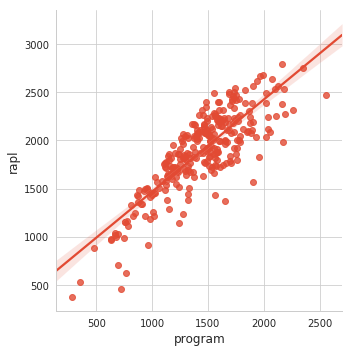

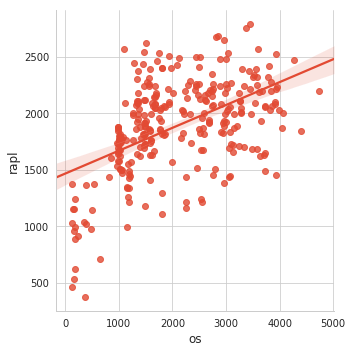

In [81]:
print("variation")
sns.lmplot(data=x.loc[x["mode"]=="LU"],x="program",y="rapl")
sns.lmplot(data=x.loc[x["mode"]=="LU"],x="os",y="rapl")

energy


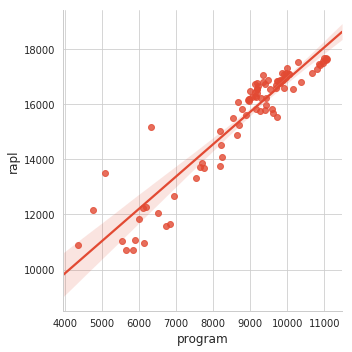

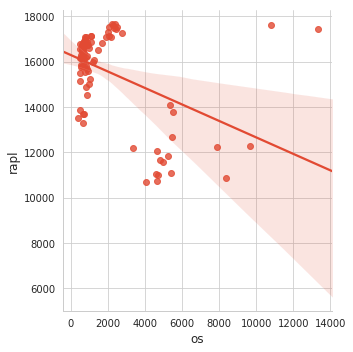

In [82]:
print("energy")
sns.lmplot(data=z.loc[z["mode"]=="LU"],x="program",y="rapl")
sns.lmplot(data=z.loc[z["mode"]=="LU"],x="os",y="rapl")


In [20]:

sns.catplot(data=x.loc[x["mode"]=="CG"] ,\
            x="os",\
            y="rapl",\
            col="sensor"
            kind="swarm"
           )

SyntaxError: invalid syntax (<ipython-input-20-29f4526b0c18>, line 6)

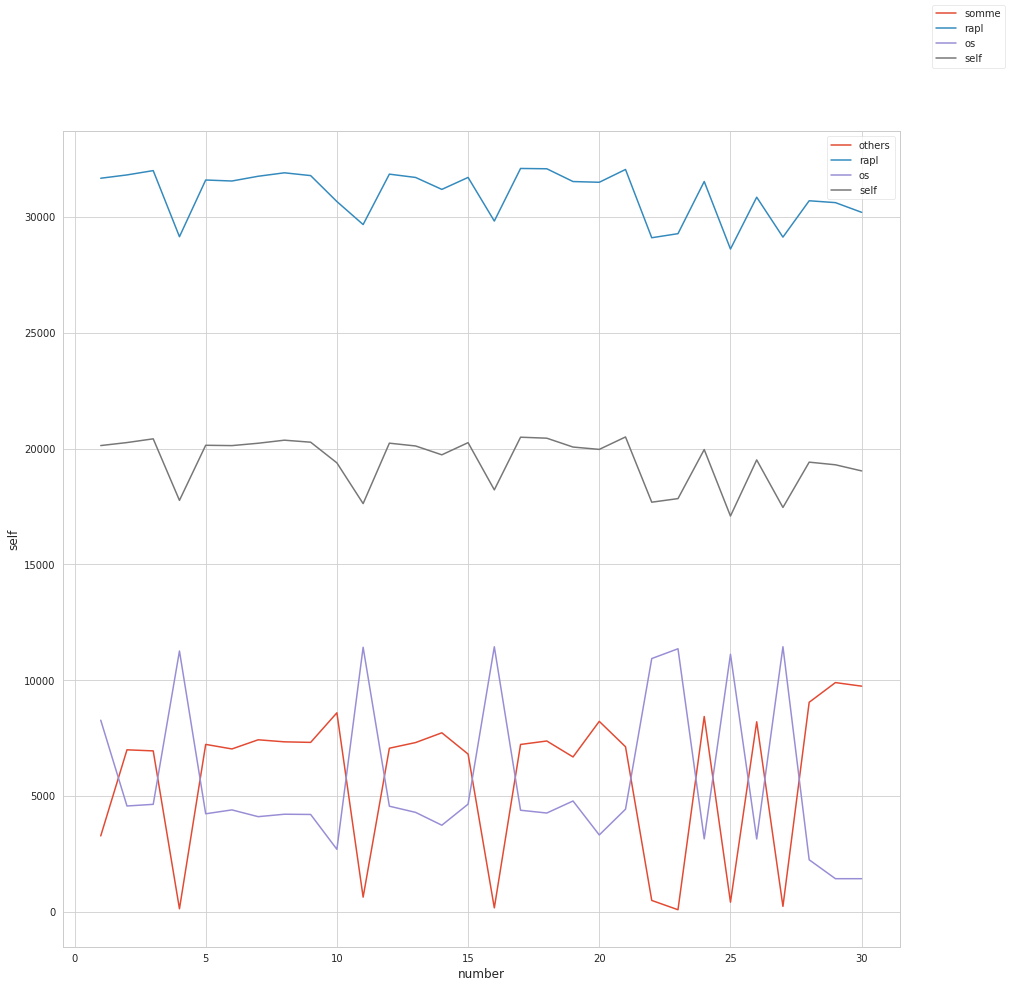

In [125]:
fig=plt.figure(figsize=(15,15))
sns.lineplot(data=x,x="number",y="somme",label="others")
sns.lineplot(data=x,x="number",y="rapl",label="rapl")
sns.lineplot(data=x,x="number",y="os",label="os")
sns.lineplot(data=x,x="number",y="self",label="self")
fig.legend(labels=["somme","rapl","os","self"])


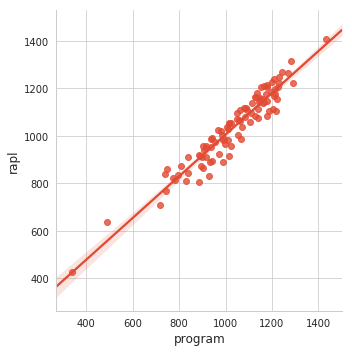

In [57]:
sns.lmplot(data=x.loc[np.logical_and(x["mode"]=="LU",x["sensor"]=="dahu-25")],x="program",y="rapl")



In [48]:
sns.scatterplot(data=x.loc[x["mode"]=="CG",x["sensor"]=="dahu-25"],x="os",y="program")

SyntaxError: invalid syntax (<ipython-input-48-19203afc858f>, line 1)

In [75]:
dt=x.loc[np.logical_and(x["mode"]=="LU",x["sensor"]=="dahu-28")]
x=x.loc[x["mode"]!="EP"]
y
x.groupby(["mode","sensor"]).corr()


program        os      rapl    number
mode sensor                                                 
CG   dahu-25 program  1.000000  0.803150  0.959190 -0.065277
             os       0.803150  1.000000  0.709778 -0.047977
             rapl     0.959190  0.709778  1.000000 -0.054247
             number  -0.065277 -0.047977 -0.054247  1.000000
     dahu-27 program  1.000000  0.906483  0.919983  0.050994
             os       0.906483  1.000000  0.871331  0.062104
             rapl     0.919983  0.871331  1.000000  0.024057
             number   0.050994  0.062104  0.024057  1.000000
     dahu-28 program  1.000000  0.951063  0.965319 -0.173770
             os       0.951063  1.000000  0.871500 -0.116475
             rapl     0.965319  0.871500  1.000000 -0.197992
             number  -0.173770 -0.116475 -0.197992  1.000000
LU   dahu-25 program  1.000000  0.113958  0.827036 -0.004039
             os       0.113958  1.000000  0.218558  0.072667
             rapl     0.827036  0.218558  1.000000  0.093703
             number  -0.004039  0.072667  0.093703  1.000000
     dahu-27 program  1.000000  0.693164  0.865786 -0.093221
             os       0.693164  1.000000  0.638298 -0.133907
             rapl     0.865786  0.638298  1.000000 -0.119830
             number  -0.093221 -0.133907 -0.119830  1.000000
     dahu-28 program  1.000000  0.621350  0.828388 -0.025242
             os       0.621350  1.000000  0.835806  0.037853
             rapl     0.828388  0.835806  1.000000 -0.040076
             number  -0.025242  0.037853 -0.040076  1.000000

In [76]:
energy3.groupby(["sensor","mode"]).count()

target  rapl  self  os  number
sensor  mode                                
dahu-25 CG        30    30    30  30      30
        EP         5     5     5   5       5
        LU        30    30    30  30      30
dahu-27 CG        30    30    30  30      30
        EP         8     8     8   8       8
        LU        30    30    30  30      30
dahu-28 CG        30    30    30  30      30
        EP        11    11    11  11      11
        LU        30    30    30  30      30

In [ ]:
dt3=energy3.melt(id_vars=["target","sensor","mode","number"],var_name="methode",value_name="energy")

In [87]:
z.head()

,sensor,target,rapl,program,os,mode,number,gp
ind,,,,,,,,
normal_normal_CG_B_1_1,dahu-25,normal_normal_CG_B_1_1,31677.468048,20132.133620,8270.524898,CG,1,dahu-25 CG
normal_normal_CG_B_1_10,dahu-25,normal_normal_CG_B_1_10,30671.106964,19384.846443,2695.451751,CG,10,dahu-25 CG
normal_normal_CG_B_1_11,dahu-25,normal_normal_CG_B_1_11,29677.083099,17625.418613,11420.846748,CG,11,dahu-25 CG
normal_normal_CG_B_1_12,dahu-25,normal_normal_CG_B_1_12,31854.056152,20235.464976,4557.402597,CG,12,dahu-25 CG
normal_normal_CG_B_1_13,dahu-25,normal_normal_CG_B_1_13,31710.505310,20114.449608,4290.276275,CG,13,dahu-25 CG


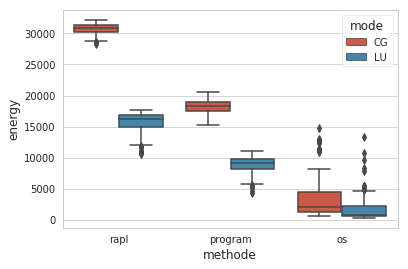

In [91]:
sns.boxplot(data=dtz,x="methode",y="energy",hue="mode")

In [89]:
dtz=z.melt(id_vars=["target","sensor","mode","gp","number"],var_name="methode",value_name="energy")
dtz.head()

,target,sensor,mode,gp,number,methode,energy
0,normal_normal_CG_B_1_1,dahu-25,CG,dahu-25 CG,1,rapl,31677.468048
1,normal_normal_CG_B_1_10,dahu-25,CG,dahu-25 CG,10,rapl,30671.106964
2,normal_normal_CG_B_1_11,dahu-25,CG,dahu-25 CG,11,rapl,29677.083099
3,normal_normal_CG_B_1_12,dahu-25,CG,dahu-25 CG,12,rapl,31854.056152
4,normal_normal_CG_B_1_13,dahu-25,CG,dahu-25 CG,13,rapl,31710.505310


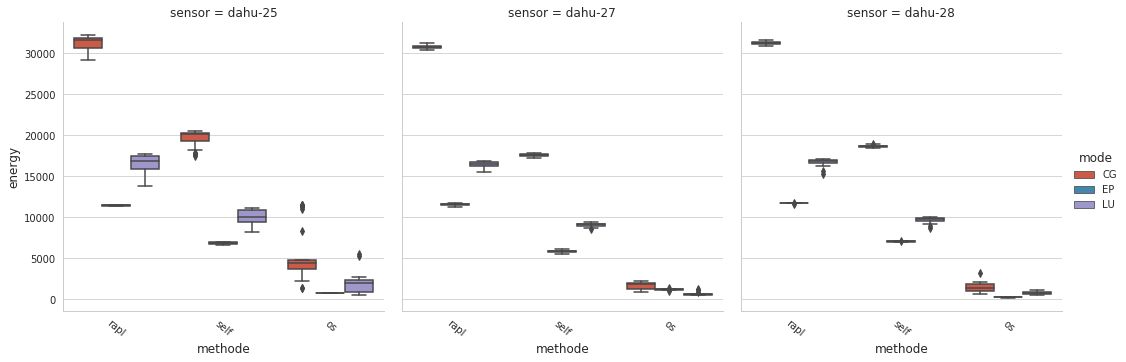

In [61]:
sns.set_style("whitegrid")

g=sns.catplot(y="energy",
               x="methode",
               data=dt3,
              hue="mode", 
              col="sensor",
              kind="box",
#               notch=True,
#               palette=p2
#              facet_kws={"orient":"h"}
             )
g.set_xticklabels(rotation=-40)

In [ ]:
dt2["mode"]=dt2["target"].apply(lambda row:row.split("_")[2] )
dt2["number"]=dt2["target"].apply(lambda row:int(row.split("_")[-1]) )

In [22]:
show(dt2)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [ ]:
n=4
i=machines[n]
x=pd.DataFrame(list(db["power"+i].find()))
x=getRAPLDATA(x)
y=getTimes(i) 
# z=y
# z[["cpu 0","cpu 1","dram 0","dram 1"]]=z.apply(lambda row:x.loc[np.logical_and(np.logical_and(row["end"]>=x["tt"],x["tt"]>= row["begin"]),x["sensor"]==row["sensor"]),["cpu 0","cpu 1","dram 0","dram 1"]].apply(np.trapz),axis=1)
# z["cpu"]=z.apply(lambda row : row["cpu 1"]+row["cpu 0"],axis=1 )
# z["dram"]=z.apply(lambda row : row["dram 1"]+row["dram 0"],axis=1 )


In [ ]:
show(x)

In [ ]:
# n=2
# i=machines[n]
# x=pd.DataFrame(list(db["power"+i].find()))
# x=getRAPLDATA(x)
# y=getTimes(i) 
# z=y
# z[["cpu 0","cpu 1","dram 0","dram 1"]]=z.apply(lambda row:x.loc[np.logical_and(np.logical_and(row["end"]>=x["tt"],x["tt"]>= row["begin"]),x["sensor"]==row["sensor"]),["cpu 0","cpu 1","dram 0","dram 1"]].apply(np.trapz),axis=1)
# z["cpu"]=z.apply(lambda row : row["cpu 1"]+row["cpu 0"],axis=1 )
# z["dram"]=z.apply(lambda row : row["dram 1"]+row["dram 0"],axis=1 )
# rapls.append()

rapls=[ pd.DataFrame(list(db["power"+i].find())) for i in machines]
rapls=[getRAPLDATA(i)for i in rapls]
times=[getTimes(i)for i in machines]
alldata=pd.concat(rapls)
rapl=pd.concat(rapls)
time=pd.concat(times)
# x.to_csv("dockervsbin.csv",sep=";")

In [ ]:

energy=time
energy[["cpu 0","cpu 1","dram 0","dram 1"]]=time.apply(lambda row:rapl.loc[np.logical_and(np.logical_and(row["end"]>=rapl["tt"],rapl["tt"]>= row["begin"]),rapl["sensor"]==row["sensor"]),["cpu 0","cpu 1","dram 0","dram 1"]].apply(np.trapz),axis=1)
energy["cpu"]=energy.apply(lambda row : row["cpu 1"]+row["cpu 0"],axis=1 )
energy["dram"]=energy.apply(lambda row : row["dram 1"]+row["dram 0"],axis=1 )
# energy["name"]=energy.index
# energy[["mode","mode2","benchmark","class","cpu number","p","number"]]=energy["name"].str.split("_",expand=True)
# energy["number"]=times.apply(lambda row:int(row["p"]) if row["number"]==None else int(row["number"]),axis=1)
#     times["sensor"]=x["sensor"][0]
    
# energy["number"]=energy["number"].apply(lambda row:int(row))
# energy=energy.drop("tt",axis=1)
# row=times.iloc[0]
# row
# rapl.loc[np.logical_and(rapl["tt"]>= row["begin"],rapl["tt"]<=row["end"] )].sum()
# print(np.logical_and([True,True ,False]))
show(energy)

In [ ]:
energy.to_csv("runningtest.csv")

In [ ]:
energy["name"]=energy.index
energy[["mode","mode2","benchmark","class","cpu number","p","number"]]=energy["name"].str.split("_",expand=True)
energy["number"]=energy.apply(lambda row:int(row["p"]) if row["number"]==None else int(row["number"]),axis=1) #times["sensor"]=x["sensor"][0]
    
energy["number"]=energy["number"].apply(int)
# energy=energy.drop("tt",axis=1)
show(energy)

In [ ]:
energy2= energy.copy()

In [ ]:
energy2["mode2"]=energy2.apply(lambda row:"sleep"if row["mode"]=="sleep" else row["mode2"] ,axis=1)
energy2["mode"]=energy2.apply(lambda row:"normal"if row["mode"]=="sleep" else row["mode"] ,axis=1)
energy2=energy2.loc[energy2["mode2"]!="cacheclean"]
energy2=energy2.loc[energy2["sensor"]!="rebootxDahu10"]
energy2.to_csv("runningtestcleaned.csv")

In [ ]:
show(energy2)

In [ ]:
energylu=energy2.loc[energy2["benchmark"]=="LU"]

In [ ]:
energycg=energy2.loc[energy2["benchmark"]=="CG"]

In [ ]:
fig = plt.figure(figsize=(15,10))

sns.violinplot(data=energycg,x="mode2",y="cpu")


In [ ]:
energylu.groupby("mode2").count()

In [ ]:
def bootstrap(energy,groupbyobj="mode2",sampleSize=40): 
    l=[(energy.loc[energy[groupbyobj]==x ],x) for x in energy[groupbyobj].drop_duplicates() ]
#     l=[np.random.choice(x["cpu"], size=(5000, sampleSize))for x in l]
#     return l
    l=[(np.random.choice(i["cpu"], size=(5000, sampleSize)),j) for i,j in l ]
    l=[(np.std(i,1),j) for i,j in l]
    l2=[]
    for i,j in l:
        data=pd.DataFrame()
        data["val"]=i
        data[groupbyobj]=j
        l2.append(data)
    return l,pd.concat(l2)


# data["val"]=btdocker
# data["mode"]="docker"
# data2=pd.DataFrame()
# data2["val"]=btbinarry
# data2["mode"]="binarry"
#     return pd.concat(l)
e2,_=bootstrap(energycg)

In [ ]:
import scipy as sc
# print("shapiro docker : "+str(sc.stats.shapiro(btdocker)))
# print("shapiro binarry : "+str(sc.stats.shapiro(btbinarry)))
# print("wilcoxon: "+str(sc.stats.wilcoxon(btdocker,btbinarry)))
print("mannwhitneyu: "+str(sc.stats.mannwhitneyu(btchetemi,btecotype,alternative="less")))
# print("t-test: "+str(sc.stats.ttest_ind(btbinarry,btdocker)))


In [ ]:
fig = plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
legends=[]
for i,j in e2: 
    sns.distplot(i,label=j)
    legends.append(j)
fig.legend(labels=legends)

plt.show()

In [ ]:
e3,_=bootstrap(energylu)
fig = plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
legends=[]
for i,j in e3: 
    sns.distplot(i,label=j)
    legends.append(j)
fig.legend(labels=legends)

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(btdahu,label="dahu")
sns.distplot(btchetemi,label="chetemi")
sns.distplot(btecotype,label="ecotype")
fig.legend(labels=['dahu','chetemi',"ecotype"])
plt.show()

In [ ]:
sampleSize=15
energylu=energy.loc[energy["benchmark"]=="CG"]
energy2=cleanData( energylu,groupobj="sensor",measure="cpu")

dahu = energy2.loc[energy2["sensor"]=="genxDahu2",["cpu"]]
chetemi=energy2.loc[energy2["sensor"]=="genxChetemi11",["cpu"]]
ecotype=energy2.loc[energy2["sensor"]=="genxEcotype5",["cpu"]]
np.random.seed=123444123
# print(meandocker)
# dockers["cpu"]=dockers.apply(lambda x: x["cpu"]-meandocker,axis=1)
# binarries["cpu"]=binarries.apply(lambda x : x["cpu"]-meanbinarry,axis=1)
# btdahu=sns.algorithms.bootstrap(dahu,n_boot=1000,func=len,seed=12344123)


show(dahu)
# btbinarry=sns.algorithms.bootstrap(binarries,n_boot=1000,func=np.std,seed=12344123)
btdahu= np.random.choice(dahu["cpu"], size=(5000, sampleSize))
btdahu=np.std(btdahu,1)

btchetemi= np.random.choice(chetemi["cpu"], size=(5000, sampleSize))
btchetemi=np.std(btchetemi,1)

btecotype= np.random.choice(ecotype["cpu"], size=(5000, sampleSize))
btecotype=np.std(btecotype,1)


# print(np.std(binaries))
# print(np.std(dockers))
# show(energy2)
# print("Docker: real value: {} , bt mean {}".format(np.std(dockers["cpu"]),np.mean(btdocker)))
# print("binarry:real value: {} , bt mean {}".format(np.std(binarries["cpu"]),np.mean(btbinarry)))
xtics=x = np.linspace(0, 1, len(btdahu))
# btdocker

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(btdahu,label="dahu")
sns.distplot(btchetemi,label="chetemi")
sns.distplot(btecotype,label="ecotype")
fig.legend(labels=['dahu','chetemi',"ecotype"])
plt.show()

In [ ]:
print("mannwhitneyu: "+str(sc.stats.mannwhitneyu(btchetemi,btecotype,alternative="greater")))

In [ ]:
data=pd.DataFrame()
data["val"]=btdocker
data["mode"]="docker"
data2=pd.DataFrame()
data2["val"]=btbinarry
data2["mode"]="binarry"

data=pd.concat([data,data2])
# show(data)

In [ ]:
sns.boxplot(data=data,x="mode",y="val").set_title("energy variation , docker vs binarry")

In [ ]:
0664909870